# Getting started with exploratory data analysis

## Install and import required libraries

In [8]:
%bash
pip install sns

In [10]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import google.datalab.bigquery as bq
import sns

In [2]:
#
# Count number of rows 
#
!bq query "SELECT COUNT(DEP_DELAY) FROM flights.fedtzcorr"



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Waiting on bqjob_rccff3eced8ee209_0000017199de54a9_1 ... (23s) Current status: DONE   
+--------+
|  f0_   |
+--------+
| 235208 |
+--------+


In [3]:
!bq query "SELECT COUNT(DEP_DELAY) FROM flights.fedtzcorr WHERE RAND() < 0.1"

Waiting on bqjob_r69d94e4e46b72afe_0000017199dee75b_1 ... (14s) Current status: DONE   
+-------+
|  f0_  |
+-------+
| 23488 |
+-------+


In [6]:
#
# Second query selects random rows 1% of which departure delay is below 10 minutes 
#

sql2 = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.fedtzcorr`
WHERE DEP_DELAY < 10 AND RAND() < 0.01
"""

df = bq.Query(sql2).execute().result().to_dataframe()

df.describe()

,ARR_DELAY,DEP_DELAY
count,1696.000000,1703.000000
mean,-8.790094,-2.825602
std,14.193963,4.820954
min,-57.000000,-24.000000
25%,-17.000000,-6.000000
50%,-10.000000,-3.000000
75%,-2.000000,0.000000
max,118.000000,9.000000


## Violin Plot

/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:584: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:812: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


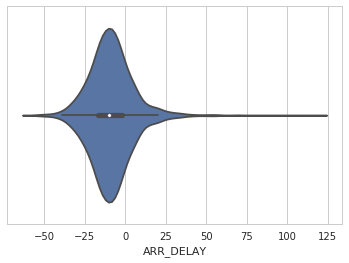

In [7]:
sb.set_style("whitegrid")
ax = sb.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')

## Comparing violin plot for flights depart delay 10min< and <10min

/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:584: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:812: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(-50, 200)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


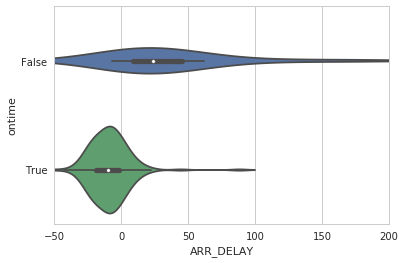

In [14]:
#
# Pull random 1% data from the dataset
#

sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.fedtzcorr`
WHERE RAND() < 0.001
"""

df = bq.Query(sql).execute().result().to_dataframe()

df['ontime'] = df['DEP_DELAY'] < 10

sb.set_style("whitegrid")
ax = sb.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h', gridsize=1000)
ax.set_xlim(-50, 200)

In [9]:
# Calculating linear model
quality_controll_tholds = [1000, 500, 370, 200, 100, 22, 10, 5]

for t in quality_controll_tholds:
  sql = """
  SELECT 
    235208 - SUM(numflights) AS num_removed,
    # 期待値の平均から計算
    AVG(arrival_delay * numflights)/AVG(DEP_DELAY * numflights) AS lm 
  FROM (
    SELECT
      DEP_DELAY,
      AVG(ARR_DELAY) AS arrival_delay,
      STDDEV(ARR_DELAY) AS stddev_arrival_delay,
      COUNT(ARR_DELAY) AS numflights
    FROM
      `flights.fedtzcorr`
    GROUP BY
      DEP_DELAY
    HAVING
      numflights > 370
    ORDER BY
      DEP_DELAY
  )
  WHERE numflights > {0}
  """.format(t)

  df = bq.Query(sql).execute().result().to_dataframe()

  print("Threshold on numflights: {0}, num_removed: {1}, lm: {2}".format(t, df['num_removed'][0], df['lm'][0] ))

Threshold on numflights: 1000, num_removed: 41584, lm: -40.90971277004159
Threshold on numflights: 500, num_removed: 28079, lm: -1.984851368413238
Threshold on numflights: 370, num_removed: 22050, lm: -0.8626992250329018
Threshold on numflights: 200, num_removed: 22050, lm: -0.8626992250329018
Threshold on numflights: 100, num_removed: 22050, lm: -0.8626992250329018
Threshold on numflights: 22, num_removed: 22050, lm: -0.8626992250329018
Threshold on numflights: 10, num_removed: 22050, lm: -0.8626992250329018
Threshold on numflights: 5, num_removed: 22050, lm: -0.8626992250329018


## Hexbin plot

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


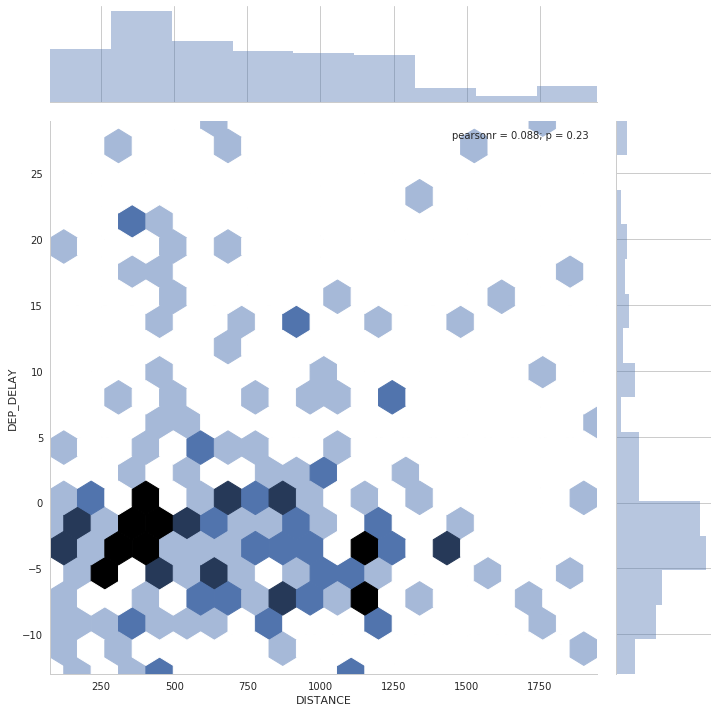

In [16]:
sql = """
SELECT DISTANCE, DEP_DELAY
FROM `flights.fedtzcorr`
WHERE RAND() < 0.001 AND dep_delay > -20
  AND dep_delay < 30 AND distance < 2000
"""

df = bq.Query(sql).execute().result().to_dataframe()
sb.set_style("whitegrid")

# Examples 
# With hexagon plot
g = sb.jointplot(df['DISTANCE'], df['DEP_DELAY'], kind='hex', size=10, joint_kws={'gridsize': 20})

# With scatter plot
#g = sb.jointplot(df['DISTANCE'], df['DEP_DELAY'], kind='scatter')